# Задание:

Предсказать какие следующие 5 товаров купят клиенты магазина.

НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекомендательные системы в проекте. Данные следующие:

• hh_demographic.csv - фичи пользователей.

• product.csv - фичи товарова.

• retail_train.csv - взаимодействие пользователей с товарами.

• test_users.csv - список пользователей для которого необходимо предоставить предсказания.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import lightgbm

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
def ap_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(1, k+1):
        
        if flags[i - 1] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i)
     #             print(p_k)
            
            sum_ += p_k
            
    result = sum_ / min(len(recommended_list), k)
    
    return result

In [3]:
data = pd.read_csv('data/retail_train.csv')

In [4]:
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 5
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
# Статистики будем собирать на data_train
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]

# Оставляю юзеров более чем 4 итемов

In [6]:
data_train_lvl_1.shape

(2136728, 12)

In [7]:
data_train_lvl_2.shape

(141762, 12)

In [8]:
users_over_5_items = data_train.groupby('user_id')['item_id'].nunique().reset_index()\
            .rename(columns = {'item_id': 'nunique_item_id'})
users_over_5_items = users_over_5_items[users_over_5_items['nunique_item_id'] > 4]
users_over_5_items = users_over_5_items['user_id'].to_list()

In [9]:
data_train_lvl_1 = data_train_lvl_1.query('user_id in @users_over_5_items')
data_train_lvl_2 = data_train_lvl_2.query('user_id in @users_over_5_items')

In [10]:
data_train_lvl_1.shape

(2136720, 12)

In [11]:
data_train_lvl_2.shape

(141758, 12)

# Добавляю фичи итемов в data

In [12]:
item_feat_to_data=item_features.groupby(['item_id'], as_index=False)['department', 'commodity_desc'].max()

/tmp/ipykernel_6932/3101565759.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  item_feat_to_data=item_features.groupby(['item_id'], as_index=False)['department', 'commodity_desc'].max()


In [13]:
data = data.merge(item_feat_to_data, how='left', on='item_id')

In [14]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,department,commodity_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,PRODUCE,POTATOES
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,PRODUCE,ONIONS


In [15]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 84180 to 5001


In [16]:
data_train_lvl_1.shape

(2095627, 13)

In [17]:
data_train_lvl_1 = data_train_lvl_1.loc[data_train_lvl_1['item_id'] != 999999]

In [18]:
data_train_lvl_1.shape

(1335321, 13)

In [19]:
recommender = MainRecommender(data_train_lvl_1)

2471


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [20]:
users_lvl_1 = pd.DataFrame(data_train_lvl_1['user_id'].unique())
users_lvl_1.columns = ['user_id']

# Пока только warm start
train_users_1 = data_train_lvl_1['user_id'].unique()
#users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [21]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.query('user_id in @train_users_1')
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[1005186, 907466, 909497, 940947, 963542, 1067..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
result_lvl_1.shape

(2081, 2)

In [23]:
result_lvl_1['candidates_als'] = result_lvl_1.user_id.apply(lambda x: recommender.get_als_recommendations(x, N=50))

1
2
4
6
7
8
9
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
46
47
49
51
52
53
55
56
57
58
59
63
64
65
66
67
68
69
70
71
72
74
77
78
79
80
81
82
83
84
85
86
87
88
91
92
94
95
97
98
99
100
101
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
121
122
123
125
126
127
128
129
131
132
133
134
135
136
137
138
139
140
142
143
144
145
146
147
148
149
150
151
152
153
155
156
157
158
159
160
161
162
164
165
166
167
169
170
171
172
175
176
177
178
180
182
183
184
185
187
188
189
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
207
208
209
210
211
212
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
232
233
235
236
238
239
241
242
243
244
245
246
247
248
249
250
251
253
254
255
256
257
258
259
260
262
263
264
265
266
267
268
269
270
271
273
274
275
276
277
278
279
280
281
282
283
285
286
287
288
289
290
291
292
293
294
297
300
301
302
303
304
305
306
307
308
309
311
312
314
315
316
317
318
319
320
321
32

2459
2461
2462
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2477
2478
2479
2481
2482
2483
2484
2485
2486
2488
2489
2490
2492
2494
2496
2497
2498
2499
2500


In [24]:
result_lvl_1.apply(lambda x: recall_at_k(x['candidates_als'], x['actual']), axis=1).mean()*100

2.420670692238378

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [25]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

In [26]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [27]:
users_lvl_2.head(2)

,user_id,candidates
0,1827,"[1082185, 1029743, 995242, 1106523, 981760, 11..."
1,1289,"[1082185, 1029743, 995242, 1106523, 981760, 11..."


In [28]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,1827,1082185,1
0,1827,1029743,1
0,1827,995242,1
0,1827,1106523,1


In [29]:
users_lvl_2.shape[0]

104050

In [30]:
users_lvl_2['user_id'].nunique()

2081

In [31]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [32]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,1827,1082185,0.0
1,1827,1029743,1.0


(!) На каждого юзера 50 item_id-кандидатов

In [33]:
targets_lvl_2['target'].mean()

0.11971407699207516

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

In [34]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1827,1082185,0.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1827,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

# Обучаю модель

In [35]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [36]:
cat_feats = X_train.columns[2:].tolist()
cat_feats = X_train.select_dtypes(include='object').columns.tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [37]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1827,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1827,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1827,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1827,995242,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1827,1106523,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, reg_lambda=0.8)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [39]:
from sklearn.metrics import classification_report

In [40]:
y_train.value_counts()

target
0.0       95195
1.0       12946
dtype: int64

# 2nd Model validation

In [41]:
users_lvl_2_val = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [42]:
users_lvl_2_val['user_id'].isin(train_users).sum()

2030

In [43]:
s = users_lvl_2_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [44]:
users_lvl_2_val = users_lvl_2_val.drop('candidates', axis=1).join(s)

users_lvl_2_val.head(4)

,user_id,item_id
0,338,1082185
0,338,1029743
0,338,995242
0,338,1106523


In [45]:
pred_2 =users_lvl_2_val.merge(item_features, on = 'item_id', how = 'left')

In [46]:
pred_2 =pred_2.merge(user_features, on = 'user_id', how = 'left')

In [47]:
pred_2.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,338,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,338,995242,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,338,1106523,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338,981760,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Предсказания

In [48]:
X_val = pred_2

In [49]:
X_val[cat_feats] = X_val[cat_feats].astype('category')

In [50]:
val_preds = lgb.predict(X_val)

<AxesSubplot:>

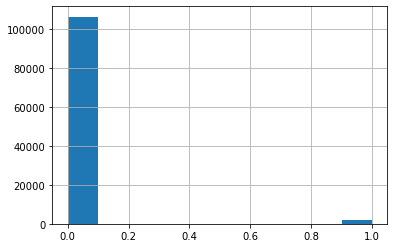

In [51]:
pd.Series(train_preds).hist()

In [52]:
val_preds = lgb.predict_proba(X_val)[:, 1]

<AxesSubplot:>

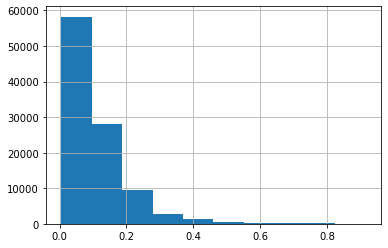

In [53]:
pd.Series(val_preds).hist()

In [54]:
pred_2.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,338,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,338,995242,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,338,1106523,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338,981760,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
pred_2['proba'] = val_preds

In [56]:
recomendations = pred_2[['user_id', 'item_id', 'proba']]

In [57]:
recomendations.head()

,user_id,item_id,proba
0,338,1082185,0.385515
1,338,1029743,0.245659
2,338,995242,0.176341
3,338,1106523,0.190166
4,338,981760,0.129454


In [58]:
recomendations.sort_values(['user_id', 'proba'],\
            ascending = False).groupby('user_id').apply(lambda x: x['item_id'].iloc[:5].values)

user_id
1         [1082185, 995242, 1029743, 840361, 1133018]
3         [1082185, 1029743, 995242, 994928, 1106523]
6         [1082185, 1029743, 995242, 994928, 1106523]
7         [1082185, 1029743, 995242, 1106523, 840361]
8         [1082185, 1029743, 995242, 883404, 1068719]
                            ...                      
2496      [1082185, 1029743, 995242, 1106523, 981760]
2497     [1082185, 1029743, 995242, 1106523, 1070820]
2498    [1082185, 1070820, 1029743, 1106523, 1068719]
2499    [1070820, 1082185, 1029743, 1106523, 1068719]
2500     [1082185, 1029743, 1106523, 1070820, 995242]
Length: 2030, dtype: object

In [59]:
lgbm_recs = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'],\
        ascending = False).groupby('user_id').apply(lambda x:\
                            x['item_id'].iloc[:5].values)).rename(columns = {0: 'lgbm'})

In [60]:
lgbm_recs.head()

,lgbm
user_id,
1,"[1082185, 995242, 1029743, 840361, 1133018]"
3,"[1082185, 1029743, 995242, 994928, 1106523]"
6,"[1082185, 1029743, 995242, 994928, 1106523]"
7,"[1082185, 1029743, 995242, 1106523, 840361]"
8,"[1082185, 1029743, 995242, 883404, 1068719]"


In [61]:
data_val_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0


In [62]:
pd.DataFrame(data_val_lvl_2.groupby('user_id')['item_id'].unique()).head()

,item_id
user_id,
1,"[821867, 834484, 856942, 865456, 889248, 90795..."
3,"[835476, 851057, 872021, 878302, 879948, 90963..."
6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
7,"[840386, 889774, 898068, 909714, 929067, 95347..."
8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [63]:
lgbm_recs = lgbm_recs.merge(pd.DataFrame(
    data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns = \
                        {'item_id': 'actual'}).reset_index(), how = 'left', on = 'user_id')

In [64]:
lgbm_recs.head()

,user_id,lgbm,actual
0,1,"[1082185, 995242, 1029743, 840361, 1133018]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1082185, 1029743, 995242, 994928, 1106523]","[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[1082185, 1029743, 995242, 994928, 1106523]","[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[1082185, 1029743, 995242, 1106523, 840361]","[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[1082185, 1029743, 995242, 883404, 1068719]","[835098, 872137, 910439, 924610, 992977, 10412..."


In [65]:
lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis = 1).mean()*100

20.384236453201687

In [66]:
lgbm_recs.apply(lambda x: ap_k(x['lgbm'], x['actual']), axis = 1).mean()*100

15.100492610837406

In [67]:
X_val.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'proba'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

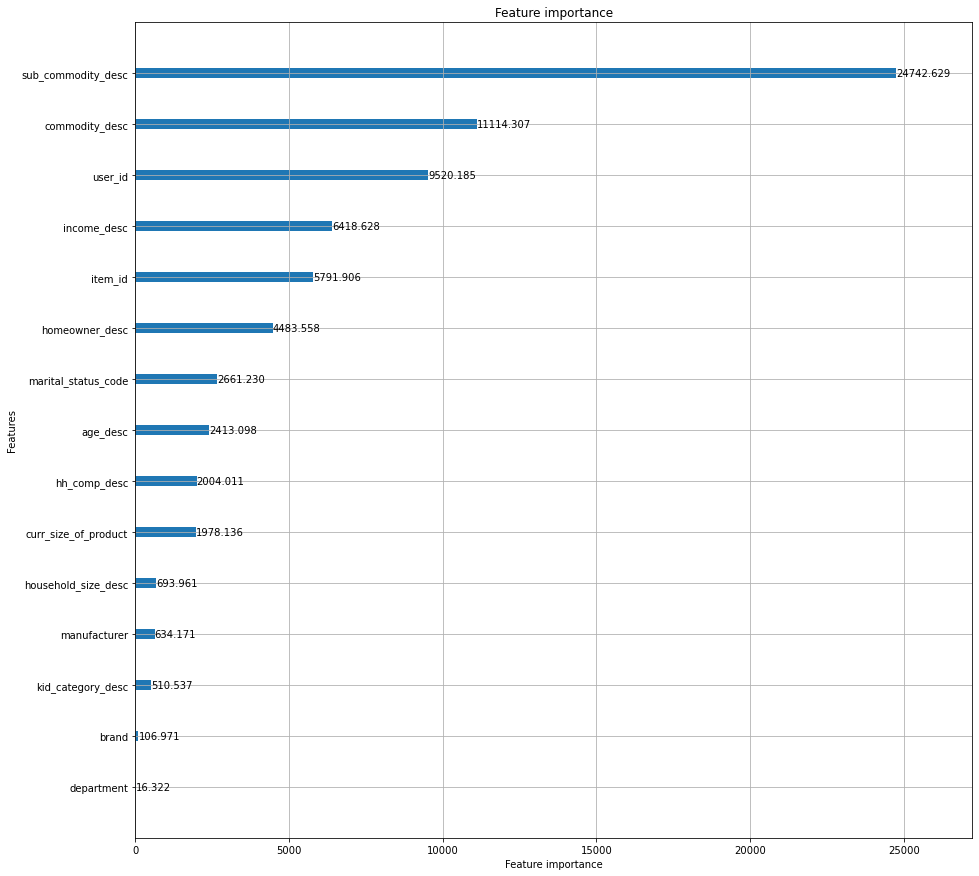

In [68]:
lightgbm.plot_importance(lgb, figsize=(15, 15), importance_type='gain')

# Pairwise

In [69]:
from lightgbm import LGBMRanker

In [70]:
groups = X_train.groupby('user_id').count().iloc[:, 0].values

In [71]:
assert sum(groups) == X_train.shape[0]

In [72]:
lgb = LGBMRanker(objective='lambdarank', max_depth=7, categorical_column=cat_feats, reg_lambda=0.5)
lgb.fit(X_train, y_train, group = groups)

train_preds = lgb.predict(X_train)

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [73]:
X_val.drop(columns=['proba'], inplace=True)

In [74]:
val_preds = lgb.predict(X_val)

<AxesSubplot:>

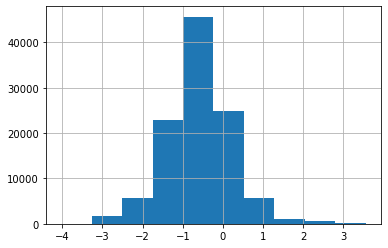

In [75]:
pd.Series(train_preds).hist()

In [76]:
pred_2['proba'] = val_preds

In [77]:
recomendations = pred_2[['user_id', 'item_id', 'proba']]

In [78]:
recomendations.head()

,user_id,item_id,proba
0,338,1082185,1.035658
1,338,1029743,0.362378
2,338,995242,0.239252
3,338,1106523,0.261757
4,338,981760,-0.216782


In [79]:
lgbm_recs = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'],\
        ascending = False).groupby('user_id').apply(lambda x:\
                            x['item_id'].iloc[:5].values)).rename(columns = {0: 'lgbm'})

In [80]:
lgbm_recs = lgbm_recs.merge(pd.DataFrame(
    data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns = \
                        {'item_id': 'actual'}).reset_index(), how = 'left', on = 'user_id')

In [81]:
lgbm_recs.head()

,user_id,lgbm,actual
0,1,"[1082185, 995242, 1029743, 840361, 1070820]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1082185, 1029743, 995242, 962568, 1106523]","[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[1082185, 1029743, 995242, 962568, 1106523]","[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[1082185, 1029743, 995242, 1068719, 1070820]","[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[1082185, 1029743, 1068719, 995242, 1044078]","[835098, 872137, 910439, 924610, 992977, 10412..."


In [82]:
lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis = 1).mean()*100

20.157635467980004

In [83]:
lgbm_recs.apply(lambda x: ap_k(x['lgbm'], x['actual']), axis = 1).mean()*100

15.02479474548435

Классификатор показал большее значение (еще не знал как проверять а/в-тестом спорные ситуации).

In [84]:
X_val.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'proba'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

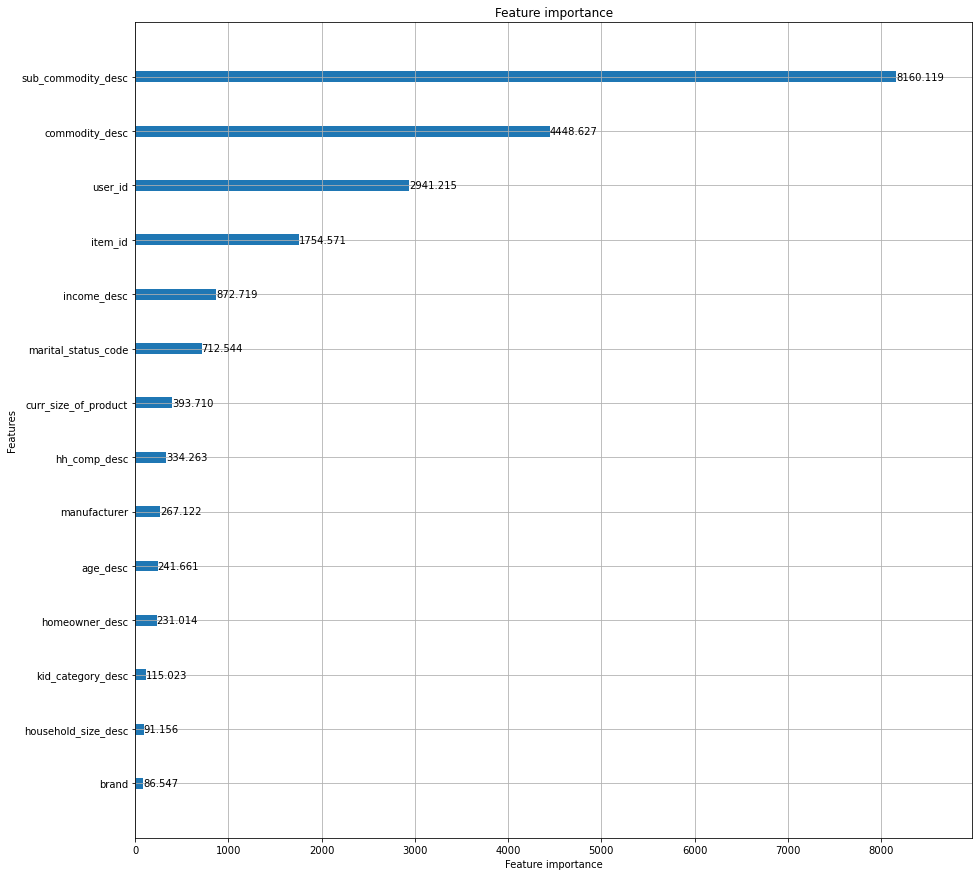

In [85]:
lightgbm.plot_importance(lgb, figsize=(15, 15), importance_type='gain')